In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sl
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import xgboost as xgb

In [3]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Data Science II/Group Project/Clean_Dataset.csv')

In [4]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [6]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [7]:
df = df.drop(columns=['Unnamed: 0'])

In [8]:
X = df.drop(['price'], axis=1)
y = df['price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preprocessing building model and Pipeline 

In [34]:
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    # Add more parameters here if needed
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(pipeline, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit grid_search to the data
grid_search_rf.fit(X_train, y_train)

# Find the best parameters and the corresponding MAE
best_params_rf = grid_search_rf.best_params_
best_mae_rf = abs(grid_search_rf.best_score_)

print("Best Parameters for RandomForest:", best_params_rf)
print("Best MAE for RandomForest:", best_mae_rf)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning

Best Parameters for RandomForest: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150}
Best MAE for RandomForest: 831.9914018275842


In [10]:
numeric_features = ['duration', 'days_left']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

Fit the model(pipeline) on the training data

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['airline', 'flight',
                                                   'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=10, n_jobs=-1,
                                       random_state=42))])

In [12]:
y_pred = pipeline.predict(X_test)

In [13]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df)

        Actual  Predicted
27131     7366     6879.4
266857   64831    70375.0
141228    6195     6195.0
288329   60160    60160.0
97334     6578     6578.0
...        ...        ...
5234      5026     5078.7
5591      3001     2995.8
168314    6734     6524.0
175191    5082     5244.0
287693   66465    71191.5

[60031 rows x 2 columns]


In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'RMSE: {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')


Mean Squared Error: 11729744.91540011
RMSE: 3424.8715180864974
Mean Absolute Error (MAE): 1962.8861618335573
R2 Score: 0.9772451051823939


In [16]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

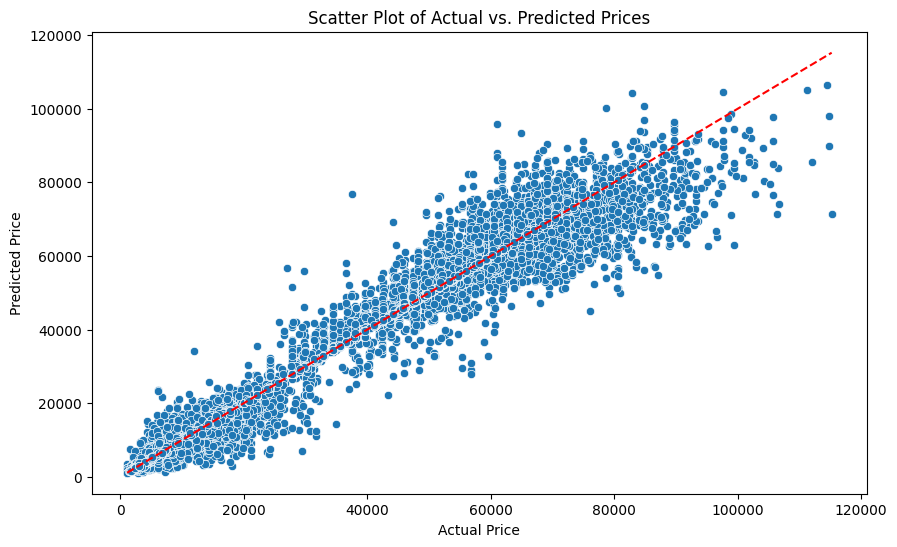

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot of Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Scatter Plot of Actual vs. Predicted Prices')
plt.show()

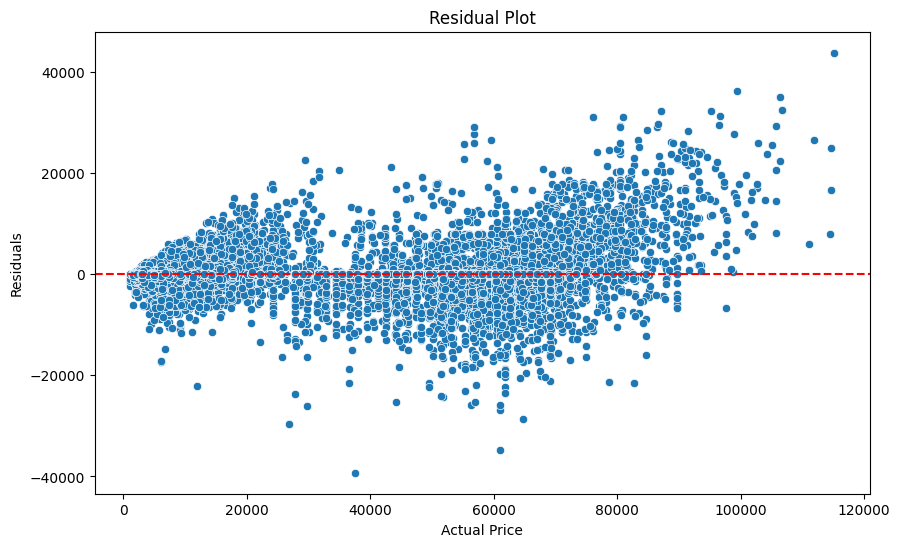

In [18]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

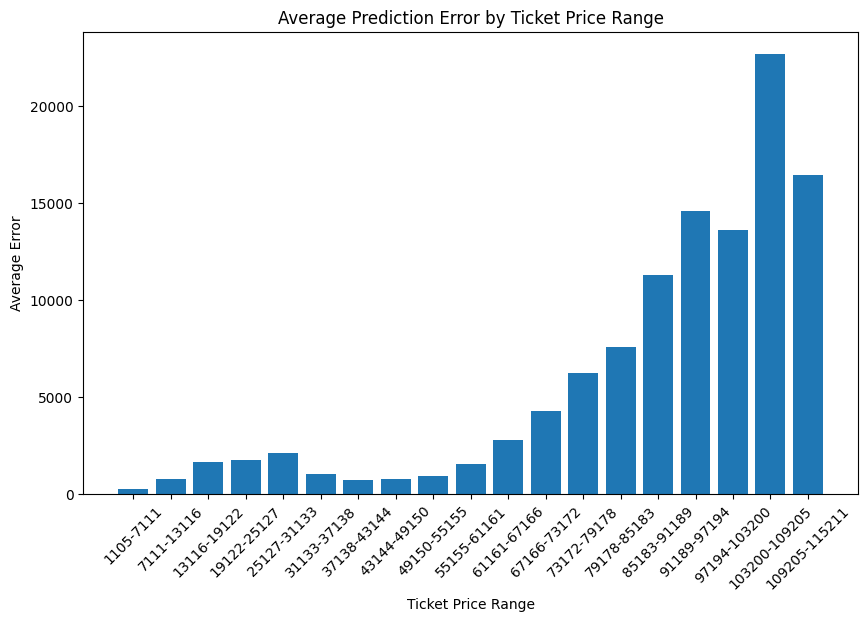

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 20

# Create bins for the ticket prices
bins = np.linspace(y_test.min(), y_test.max(), num_bins)
bin_indices = np.digitize(y_test, bins)

# Calculate average error per bin
bin_avg_error = [np.mean(abs(y_test[bin_indices == i] - y_pred[bin_indices == i])) for i in range(1, len(bins))]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(bins)), bin_avg_error, align='center')
plt.xticks(range(1, len(bins)), [(f'{bins[i]:.0f}-{bins[i+1]:.0f}') for i in range(num_bins-1)], rotation=45)
plt.xlabel('Ticket Price Range')
plt.ylabel('Average Error')
plt.title('Average Prediction Error by Ticket Price Range')
plt.show()


In [20]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


In [21]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

mean_cv_score = np.mean(cv_scores)

mean_cv_score = abs(mean_cv_score)


In [22]:
print(mean_cv_score)

3724.464054314204


In [30]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1))
])

from sklearn.model_selection import GridSearchCV

# Define a range of parameters for XGBoost
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, 10],
    # Add more parameters here if needed
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit grid_search to the data
grid_search.fit(X_train, y_train)

# Best parameters and MAE
best_parameters = grid_search.best_params_
best_mae = abs(grid_search.best_score_)

print("Best Parameters:", best_parameters)
print("Best MAE:", best_mae)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__n_estimators': 150}
Best MAE: 974.0678120197081


In [33]:

optimized_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_parameters['regressor__n_estimators'],
    learning_rate=best_parameters['regressor__learning_rate'],
    max_depth=best_parameters['regressor__max_depth'],
    random_state=42,
    n_jobs=-1
)

optimized_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', optimized_regressor)
])

cv_scores = cross_val_score(optimized_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

mean_cv_score = np.mean(cv_scores)

mean_cv_score = abs(mean_cv_score)

print("Average CV MAE with Optimized Model:", mean_cv_score)


Average CV MAE with Optimized Model: 3638.880448976117


In [31]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'RMSE: {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 11729744.91540011
RMSE: 3424.8715180864974
Mean Absolute Error (MAE): 1962.8861618335573
R2 Score: 0.9772451051823939


In [37]:
feature_names = numeric_features + \
    list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features))

# Retrieve feature importances from the model
importances = pipeline.named_steps['regressor'].feature_importances_

# Map these importances to the feature names
feature_importances = dict(zip(feature_names, importances))

# Find the importance of 'days_left'
days_left_importance = feature_importances.get('days_left', 0)

print("Importance of days_left feature:", days_left_importance)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'